In [6]:
!pip install pandas matplotlib numpy gensim nltk scikit-learn beautifulsoup4
import sys





import pandas as pd #collection of functions for data processing and analysis
import matplotlib #collection of functions for scientific  visualization

from collections import Counter
import numpy as np #package for scientific computing

import matplotlib.pyplot as plt

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
df = pd.read_csv('/content/training_data_15k.csv',encoding = "ISO-8859-1")
print(df.head())


                                                File               Tag
0  \Clients\City_Services\Source_Documents\2023\R...  Source Documents
1  \Acme_Corp\Source_Data\2022\Invoices_Received.pdf  Source Documents
2   \Tech_Solutions\Accounting\2022\Profit_Loss.xlsx         Financial
3  \Bookkeeping\Johnson_Inc\General_Ledger_2021.xlsx       Bookkeeping
4  \Clients\Western_Logistics\Accounting\2022\Tax...               Tax


In [13]:

df=df[['File', 'Tag']]

In [14]:
df.head()

,File,Tag
0,\Clients\City_Services\Source_Documents\2023\R...,Source Documents
1,\Acme_Corp\Source_Data\2022\Invoices_Received.pdf,Source Documents
2,\Tech_Solutions\Accounting\2022\Profit_Loss.xlsx,Financial
3,\Bookkeeping\Johnson_Inc\General_Ledger_2021.xlsx,Bookkeeping
4,\Clients\Western_Logistics\Accounting\2022\Tax...,Tax


In [15]:
df.dtypes

,0
File,object
Tag,object


In [16]:
df.isnull().sum()

,0
File,0
Tag,0


In [17]:
df_notnull=df[df.Tag.notnull()]
df_null=df[pd.isnull(df['Tag'])]

In [18]:
df.shape
df_notnull.shape
# df_null.shape

(12076, 2)

<Axes: xlabel='Tag'>

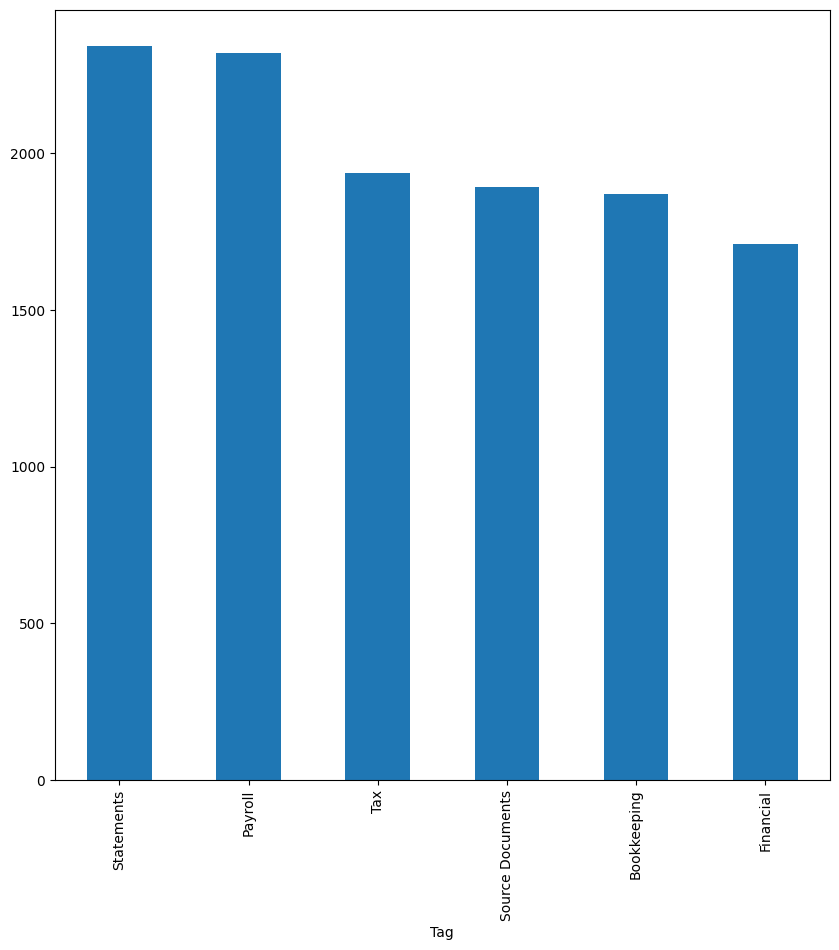

In [19]:
fig = plt.figure(figsize=(10, 10))

df_notnull['Tag'].value_counts().plot.bar()

In [20]:
df_notnull['Tag'].value_counts()

,count
Tag,
Statements,2342
Payroll,2321
Tax,1938
Source Documents,1892
Bookkeeping,1871
Financial,1712


In [23]:
df_notnull=df_notnull.loc[(df_notnull['Tag'] != 'Reconciliations') & (df_notnull['Tag']!= 'Permanent-Financial')]

In [24]:
df_notnull.shape



(12076, 2)

In [25]:
# removing Reconciliations and Permanent-Financial



## Preprocessing


In [26]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text =text.lower() # lowercase text
    text=text.replace('\\'," ")
    text=text.replace('/'," ")
    text=text.replace("-", " ")
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df_notnull['File'] = df_notnull['File'].apply(clean_text)

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-1584020623.py:1: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')


In [27]:
df_notnull['File'][0]

'clients city_services source_documents 2023 receiptspdf'

In [28]:
df_notnull['File'].apply(lambda x: len(x.split(' '))).sum()

#~1.8 Million words

np.int64(45816)

In [29]:
X = df_notnull['File']
y = df_notnull['Tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42,stratify=y)

In [30]:
tags=y.unique()

In [31]:
print(len(tags))

6



Vectorization:
TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator. vocabulary_ Is a dictionary that converts each token (word) to feature index in the matrix

In [32]:
#naive bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=tags))
print(classification_report(y_test, y_pred))

accuracy 0.9238158330573037
                  precision    recall  f1-score   support

     Bookkeeping       1.00      0.87      0.93       468
       Financial       1.00      0.90      0.95       428
         Payroll       1.00      0.93      0.97       580
Source Documents       1.00      0.93      0.96       473
      Statements       0.72      1.00      0.84       586
             Tax       1.00      0.90      0.95       484

        accuracy                           0.92      3019
       macro avg       0.95      0.92      0.93      3019
    weighted avg       0.95      0.92      0.93      3019



In [33]:
#linear SVM

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.937065253395164
                  precision    recall  f1-score   support

     Bookkeeping       0.71      1.00      0.83       468
       Financial       1.00      0.90      0.95       428
         Payroll       1.00      0.93      0.97       580
Source Documents       1.00      0.93      0.96       473
      Statements       1.00      0.96      0.98       586
             Tax       1.00      0.90      0.95       484

        accuracy                           0.94      3019
       macro avg       0.95      0.94      0.94      3019
    weighted avg       0.96      0.94      0.94      3019



In [34]:
# from sklearn.svm import SVC
# sgd = Pipeline([('vect', CountVectorizer()),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', SVC(C=10,kernel='rbf'))])


# sgd.fit(X_train, y_train)

# y_pred = sgd.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.05, max_depth= 4, n_estimators=100,min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt'))])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9284531301755549
                  precision    recall  f1-score   support

     Bookkeeping       1.00      0.87      0.93       468
       Financial       1.00      0.90      0.95       428
         Payroll       0.73      1.00      0.84       580
Source Documents       1.00      0.93      0.96       473
      Statements       1.00      0.96      0.98       586
             Tax       1.00      0.89      0.94       484

        accuracy                           0.93      3019
       macro avg       0.95      0.92      0.93      3019
    weighted avg       0.95      0.93      0.93      3019



In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


accuracy 0.9327591917853594
                  precision    recall  f1-score   support

     Bookkeeping       1.00      0.87      0.93       468
       Financial       1.00      0.90      0.95       428
         Payroll       1.00      0.93      0.97       580
Source Documents       1.00      0.93      0.96       473
      Statements       1.00      0.96      0.98       586
             Tax       0.70      1.00      0.83       484

        accuracy                           0.93      3019
       macro avg       0.95      0.93      0.93      3019
    weighted avg       0.95      0.93      0.94      3019



In [37]:
import pickle

with open('document_tagger.pkl', 'wb') as f:
    pickle.dump(logreg, f)

from google.colab import files
files.download('document_tagger.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>